# Baseline Code for HW2

This is just the baseline code to set up the basic function you need. You need to modify the code yourself to achieve a better result.

About the Dataset
The dataset used here is food-11, a collection of food images in 11 classes.

The data have been slightly modified by the TA. Please DO NOT access the original fully-labeled training data or testing labels.

## Import packages you need

In [1]:
# Import necessary packages.
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset
from torchvision.datasets import DatasetFolder

import shutil

#If you haven't download the tqdm package, just uncomment the following line.
#!pip install tqdm
# This is for the progress bar.
from tqdm.auto import tqdm

In [2]:
!pip install pytest-shutil

If you run your code in Colab, you can use the following lines to access the data you put in your google drive.
If not, just skip this.

## Dataset, Data Loader, and Transforms
Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Here, since our data are stored in folders by class labels, we can directly apply torchvision.datasets.DatasetFolder for wrapping data without much effort.

Please refer to PyTorch official website for details about different transforms.

In [3]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
transform_order = [
transforms.CenterCrop(300),
transforms.RandomRotation(35)
]
transform_apply = [
transforms.RandomVerticalFlip(0.45),
transforms.RandomHorizontalFlip(0.45)
]
"""
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    #transforms.Resize((128, 128)),
    transforms.RandomOrder(transform_order),
    transforms.RandomApply(transform_apply, p = 0.65),
    transforms.Pad(20,padding_mode='symmetric'),

    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.Resize((128, 128)),
    #transforms.Grayscale(1),
    transforms.GaussianBlur(3,7),
    transforms.ToTensor(),
    #transforms.ToPILImage()
    transforms.Normalize((0.485), (0.229))
])
"""

image_size = 224
mean = [0.554, 0.450, 0.343]
std = [0.231, 0.241, 0.241]

train_tfm = transforms.Compose([
    transforms.RandomOrder(transform_order),
    transforms.RandomApply(transform_apply, p = 0.65),
    transforms.Pad(20,padding_mode='symmetric'),
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.GaussianBlur(3,7),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])



# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 100

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("food-11/food-11/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("food-11/food-11/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("food-11/food-11/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder("food-11/food-11/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

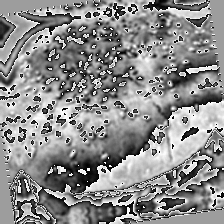

In [4]:
transforms.ToPILImage()(train_set[0][0][0])

## Model
The basic model here is simply a stack of convolutional layers followed by some fully-connected layers.

Since there are three channels for a color image (RGB), the input channels of the network must be three. In each convolutional layer, typically the channels of inputs grow, while the height and width shrink (or remain unchanged, according to some hyperparameters like stride and padding).

Before fed into fully-connected layers, the feature map must be flattened into a single one-dimensional vector (for each image). These features are then transformed by the fully-connected layers, and finally, we obtain the "logits" for each class.

WARNING -- You Must Know
You are free to modify the model architecture here for further improvement. However, if you want to use some well-known architectures such as ResNet50, please make sure NOT to load the pre-trained weights. Using such pre-trained models is considered cheating and therefore you will be punished. Similarly, it is your responsibility to make sure no pre-trained weights are used if you use torch.hub to load any modules.

For example, if you use ResNet-18 as your model:

model = torchvision.models.resnet18(pretrained=False) → This is fine.

model = torchvision.models.resnet18(pretrained=True) → This is NOT allowed.

## Training
*   You can finish supervised learning by simply running the provided code without any modification.
*   The function "get_pseudo_labels" is used for semi-supervised learning. It is expected to get better performance if you use unlabeled data for semi-supervised learning. However, you have to implement the function on your own and need to adjust several hyperparameters manually.


In [5]:
import matplotlib.pyplot as plt
def get_pseudo_labels(dataset, model, threshold):
    
    k = 0
    image_path = '/home/ai003/Desktop/t/2/food-11/food-11/labeling'
    if not os.path.exists(image_path):
        os.mkdir(image_path)

    # This functions generates pseudo-labels of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Make sure the model is in eval mode.
    model.eval()
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)

    unlabeled_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

    # Iterate over the dataset by batches.
    for batch in tqdm(unlabeled_loader):
        imgs, labels = batch

        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))
        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits)
        for index, prob in enumerate(probs):
            for i in prob:
                if i > threshold:
                    label = torch.argmax(prob)
                    img = imgs[index]
                    img = transforms.ToPILImage()(img)
                    
                    if not os.path.exists(image_path + f'/{label}'):
                        os.mkdir(image_path + f'/{label}')
                    
                    k+=1
                    img.save(f"{image_path}/{label}/{k}.png")
                    break
        
        # you may filter the data and construct a new dataset here.
    
    try:
        dataset = DatasetFolder("food-11/food-11/labeling", loader=lambda x: Image.open(x), extensions="jpg", transform=None)
        
        # need to delete folder directory after create dataset
        os.rmdir(image_path)

        # # Turn off the eval mode.
        model.train()
        return dataset
    
    except FileNotFoundError:
        print('No Class recognized by the model')
        # # Turn off the eval mode.
        model.train()
        
        if os.path.exists(image_path):
            shutil.rmtree(image_path, ignore_errors = True)
        
        return None

In [6]:
from torchvision.models import resnet101

# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"


# Initialize a model, and put it on the device specified.
#model = Classifier().to(device)
#model.device = device

model = resnet101(pretrained=True).to(device)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(nn.Linear(2048, 11),
                        nn.Softmax(dim=1))
model = model.cuda()

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss() #nn.NLLLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-5, momentum=0.9)
#lr_schedular = torch.optim.lr_schedular.StepLR(optimizer,step_size=5,gamma=0.1)

# The number of training epochs.
n_epochs = 80

# Whether to do semi-supervised learning.
do_semi = True

loss_record = {'train': [], 'dev': []}
acc_record = {'train': [], 'dev': []}

error = 1000
cnt = 0
early_stop = 10

for epoch in range(n_epochs):
    # ---------- TODO ----------
    # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
    # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
    if do_semi:
        # Obtain pseudo-labels for unlabeled data using trained model.
        try:
            if valid_acc:
                if valid_acc < 0.2:
                    threshold = 0.45
                elif valid_acc < 0.5:
                    threshold = 0.7
                elif valid_acc < 0.7:
                    threshold = 0.8
        except:
            threshold = 0.3
        pseudo_set = get_pseudo_labels(unlabeled_set, model, threshold)
        if pseudo_set == None:
            pass
        else: 
            # Construct a new dataset and a data loader for training.
            # This is used in semi-supervised learning only.
            concat_dataset = ConcatDataset([train_set, pseudo_set])
            train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.cuda()
        labels = labels.cuda()
        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    loss_record['train'].append(train_loss)
    acc_record['train'].append(train_acc)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    loss_record['dev'].append(valid_loss)
    acc_record['dev'].append(valid_acc)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    
    if valid_loss < error:
        error = valid_loss
    else:
        cnt += 1
    if cnt == early_stop:
        break

  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 001/080 ] loss = 2.39848, acc = 0.07931


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 001/080 ] loss = 2.39829, acc = 0.07333


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 002/080 ] loss = 2.39411, acc = 0.11358


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 002/080 ] loss = 2.39340, acc = 0.11048


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 003/080 ] loss = 2.38961, acc = 0.14111


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 003/080 ] loss = 2.38837, acc = 0.13571


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 004/080 ] loss = 2.38392, acc = 0.17538


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 004/080 ] loss = 2.38114, acc = 0.21095


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 005/080 ] loss = 2.37848, acc = 0.17225


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 005/080 ] loss = 2.37177, acc = 0.19333


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 006/080 ] loss = 2.36832, acc = 0.23682


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 006/080 ] loss = 2.36112, acc = 0.19238


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 007/080 ] loss = 2.35651, acc = 0.23027


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 007/080 ] loss = 2.34812, acc = 0.17905


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 008/080 ] loss = 2.34632, acc = 0.22363


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 008/080 ] loss = 2.33379, acc = 0.21714


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 009/080 ] loss = 2.33254, acc = 0.25164


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 009/080 ] loss = 2.32054, acc = 0.25238


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 010/080 ] loss = 2.31806, acc = 0.27809


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 010/080 ] loss = 2.30555, acc = 0.29810


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 011/080 ] loss = 2.30842, acc = 0.29849


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 011/080 ] loss = 2.29644, acc = 0.30619


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 012/080 ] loss = 2.29696, acc = 0.31106


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 012/080 ] loss = 2.28219, acc = 0.32381


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 013/080 ] loss = 2.28735, acc = 0.32703


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 013/080 ] loss = 2.27368, acc = 0.33857


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 014/080 ] loss = 2.27654, acc = 0.35080


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 014/080 ] loss = 2.26206, acc = 0.34905


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 015/080 ] loss = 2.26688, acc = 0.35085


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 015/080 ] loss = 2.25488, acc = 0.34619


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 016/080 ] loss = 2.25791, acc = 0.36769


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 016/080 ] loss = 2.24220, acc = 0.36905


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 017/080 ] loss = 2.25255, acc = 0.36668


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 017/080 ] loss = 2.23615, acc = 0.37000


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 018/080 ] loss = 2.24064, acc = 0.37936


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 018/080 ] loss = 2.22374, acc = 0.37429


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 019/080 ] loss = 2.23727, acc = 0.36987


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 019/080 ] loss = 2.22211, acc = 0.37857


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 020/080 ] loss = 2.22612, acc = 0.38074


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 020/080 ] loss = 2.21665, acc = 0.36810


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 021/080 ] loss = 2.22391, acc = 0.38499


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 021/080 ] loss = 2.20523, acc = 0.38238


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 022/080 ] loss = 2.22001, acc = 0.37721


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 022/080 ] loss = 2.20505, acc = 0.37667


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 023/080 ] loss = 2.21028, acc = 0.38337


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 023/080 ] loss = 2.19406, acc = 0.38714


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 024/080 ] loss = 2.20448, acc = 0.39011


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 024/080 ] loss = 2.18548, acc = 0.40190


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 025/080 ] loss = 2.19986, acc = 0.41408


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 025/080 ] loss = 2.17933, acc = 0.42905


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 026/080 ] loss = 2.19271, acc = 0.42804


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 026/080 ] loss = 2.17147, acc = 0.45857


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 027/080 ] loss = 2.19082, acc = 0.43613


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 027/080 ] loss = 2.16566, acc = 0.46571


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 028/080 ] loss = 2.18150, acc = 0.45257


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 028/080 ] loss = 2.15762, acc = 0.46571


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 029/080 ] loss = 2.17306, acc = 0.47472


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 029/080 ] loss = 2.14522, acc = 0.47810


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 030/080 ] loss = 2.16354, acc = 0.47748


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 030/080 ] loss = 2.14703, acc = 0.47333


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 031/080 ] loss = 2.16064, acc = 0.49247


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 031/080 ] loss = 2.14051, acc = 0.47810


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 032/080 ] loss = 2.15802, acc = 0.49289


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 032/080 ] loss = 2.13612, acc = 0.47857


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 033/080 ] loss = 2.14849, acc = 0.49942


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 033/080 ] loss = 2.13620, acc = 0.47143


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 034/080 ] loss = 2.14067, acc = 0.50783


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 034/080 ] loss = 2.12960, acc = 0.47762


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 035/080 ] loss = 2.13500, acc = 0.50080


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 035/080 ] loss = 2.11644, acc = 0.49286


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 036/080 ] loss = 2.13215, acc = 0.51276


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 036/080 ] loss = 2.11270, acc = 0.49524


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 037/080 ] loss = 2.13054, acc = 0.50371


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 037/080 ] loss = 2.11204, acc = 0.49095


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 038/080 ] loss = 2.12196, acc = 0.51225


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 038/080 ] loss = 2.10946, acc = 0.49667


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 039/080 ] loss = 2.12038, acc = 0.50740


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 039/080 ] loss = 2.10682, acc = 0.49238


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 040/080 ] loss = 2.10984, acc = 0.52719


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 040/080 ] loss = 2.10065, acc = 0.49810


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 041/080 ] loss = 2.10614, acc = 0.51812


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 041/080 ] loss = 2.09996, acc = 0.50190


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 042/080 ] loss = 2.10437, acc = 0.53247


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 042/080 ] loss = 2.09086, acc = 0.50714


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 043/080 ] loss = 2.10062, acc = 0.53592


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 043/080 ] loss = 2.09112, acc = 0.51286


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 044/080 ] loss = 2.09712, acc = 0.53645


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 044/080 ] loss = 2.08787, acc = 0.52000


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 045/080 ] loss = 2.08696, acc = 0.54231


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 045/080 ] loss = 2.07983, acc = 0.53619


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 046/080 ] loss = 2.08737, acc = 0.54316


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 046/080 ] loss = 2.07701, acc = 0.54667


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 047/080 ] loss = 2.08676, acc = 0.54719


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 047/080 ] loss = 2.07202, acc = 0.54238


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 048/080 ] loss = 2.08243, acc = 0.54281


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 048/080 ] loss = 2.06469, acc = 0.54857


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 049/080 ] loss = 2.07741, acc = 0.55329


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 049/080 ] loss = 2.06530, acc = 0.54286


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 050/080 ] loss = 2.07362, acc = 0.55971


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 050/080 ] loss = 2.06222, acc = 0.55762


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 051/080 ] loss = 2.07507, acc = 0.55897


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 051/080 ] loss = 2.05873, acc = 0.54619


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 052/080 ] loss = 2.07133, acc = 0.55873


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 052/080 ] loss = 2.05664, acc = 0.55333


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 053/080 ] loss = 2.06937, acc = 0.56419


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 053/080 ] loss = 2.05685, acc = 0.55238


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 054/080 ] loss = 2.05907, acc = 0.57812


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 054/080 ] loss = 2.04998, acc = 0.56000


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 055/080 ] loss = 2.05529, acc = 0.57841


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 055/080 ] loss = 2.04759, acc = 0.56095


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 056/080 ] loss = 2.05324, acc = 0.57862


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 056/080 ] loss = 2.04506, acc = 0.56524


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 057/080 ] loss = 2.05356, acc = 0.58310


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 057/080 ] loss = 2.05002, acc = 0.55095


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 058/080 ] loss = 2.04702, acc = 0.59260


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 058/080 ] loss = 2.04345, acc = 0.56190


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 059/080 ] loss = 2.04186, acc = 0.59881


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 059/080 ] loss = 2.03169, acc = 0.56952


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 060/080 ] loss = 2.04176, acc = 0.59507


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 060/080 ] loss = 2.03681, acc = 0.57524


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 061/080 ] loss = 2.03924, acc = 0.58753


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 061/080 ] loss = 2.04064, acc = 0.56190


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 062/080 ] loss = 2.03763, acc = 0.59472


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 062/080 ] loss = 2.03973, acc = 0.55667


  0%|          | 0/67 [00:00<?, ?it/s]

No Class recognized by the model


  0%|          | 0/29 [00:00<?, ?it/s]

[ Train | 063/080 ] loss = 2.03321, acc = 0.59753


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 063/080 ] loss = 2.03215, acc = 0.56857


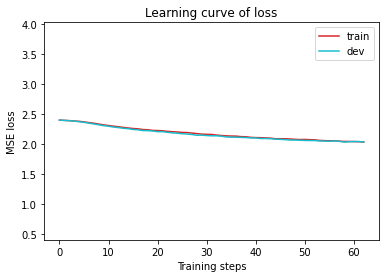

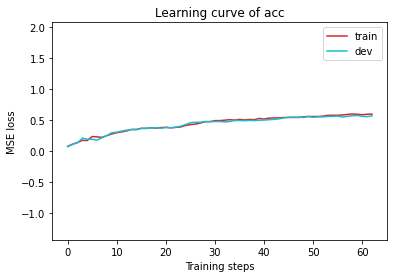

In [7]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_learning_curve(loss_record, ymin, ymax, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(ymin, ymax)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

lymin, lymax = max(loss_record['dev']), min(loss_record['dev'])
aymin, aymax = max(acc_record['dev']).cpu(), min(acc_record['dev']).cpu()



plot_learning_curve(loss_record, lymin-2, lymax+2, 'loss')
plot_learning_curve(acc_record, aymin-2, aymax+2, 'acc')

## Testing
For inference, we need to make sure the model is in eval mode, and the order of the dataset should not be shuffled ("shuffle=False" in test_loader).

In [8]:
# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
model.eval()

# Initialize a list to store the predictions.
predictions = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = model(imgs.to(device))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

  0%|          | 0/32 [00:00<?, ?it/s]

In [9]:
imgs[0][0]

tensor([[-1.7701, -1.7192, -1.6513,  ..., -0.9722, -0.9553, -0.9213],
        [-1.7192, -1.6004, -1.5664,  ..., -0.8874, -0.8534, -0.8704],
        [-1.6683, -1.5664, -1.5155,  ..., -0.7515, -0.7515, -0.8364],
        ...,
        [ 0.5217,  0.5726,  0.6066,  ...,  0.6575,  0.6745,  0.7084],
        [ 0.6066,  0.6915,  0.7763,  ...,  0.6915,  0.7084,  0.7254],
        [ 0.7763,  0.7594,  0.8273,  ...,  0.7084,  0.7424,  0.7084]])

In [10]:
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in enumerate(predictions):
         f.write(f"{i},{pred}\n")

## Hints for better result
* Design a better architecture
* Adopt different data augmentations to improve the performance.
* Utilize provided unlabeled data in training set